In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from shapely import Polygon
import geopandas as gpd

In [2]:
geom = Polygon([
    (-91.3011932, 33.852768),
    (-90.9098053, 33.8413567),
    (-90.9194183, 33.5069017),
    (-91.2957001, 33.509193),
    (-91.3005066, 33.8579026)
])

gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326")
gdf = gdf.to_crs(32615)  # UTM 15N
selected_geom = gdf.geometry.union_all().envelope

In [3]:
items_gdf = pc_query(
    collections="landsat-c2-l2",
    geometry=selected_geom,
    datetime="1984/2024",
    crs=gdf.crs,
    query={"eo:cloud_cover": {"lt": 20}}
)
print(f"Found {len(items_gdf)} items")

Found 2285 items


In [ ]:
client = Client(n_workers=8, memory_limit="2GB")
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49702,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:49722,Total threads: 2
Dashboard: http://127.0.0.1:49725/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:49705,


2025-06-29 11:58:37,878 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49740' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('isnan-ea034ebb6f620a3f271d17f875f3c9d6', 2, 0, 0)} (stimulus_id='handle-worker-cleanup-1751216317.878347')
2025-06-29 11:58:37,886 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49736' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('where-05c710007dd93fef6d5fd1c766184df5', 2, 0, 0)} (stimulus_id='handle-worker-cleanup-1751216317.886873')
2025-06-29 11:58:37,894 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:49723' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('where-05c710007dd93fef6d5fd1c766184df5', 1, 0, 0), ('isnan-ea034ebb6f620a3f271d17f875f3c9d6', 0, 0, 0), ('array-fcb15a856b93892de7fe24dd9b9c91f1', 0, 0), ('array-c644c51cd3a9040f8460a7b07df40ddc', 0, 0)} (stimu

In [5]:
da = prepare_timeseries(
    items_gdf.iloc[-128:],
    geometry=selected_geom,
    crs=gdf.crs,
    bands=["green", "nir08", "qa_pixel"],
    chunks={"time": 1, "band": -1, "x": -1, "y": -1},
    masked=True,
    max_workers=4,
)

Processing items:  97%|█████████▋| 76/78 [06:45<00:10,  5.33s/timestep]
2025-06-29 11:58:37,888 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_rasterio-original-getitem-f73b71aedf55ef2520e757d9d5157dcd', 0, 0, 0))" coro=<Worker.execute() done, defined at /Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-06-29 11:58:37,888 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_rasterio-original-getitem-227451e41e1a69889f6c96797604e0fd', 0, 0, 0))" coro=<Worker.execute() done, defined at /Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-06-29 11:58:39,887 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users

: 

: 

In [ ]:
qa = da.sel(band="qa_pixel").astype("uint32")

mask = (
    ((qa & (1 << 3)) == 0) &  # cloud
    ((qa & (1 << 4)) == 0) &  # cloud shadow
    ((qa & (1 << 5)) == 0) &  # snow
    ((qa & (1 << 7)) == 0)    # water
)

da = da.where(~mask)

In [ ]:
def dn2sr(da):
    """
    Convert Digital Number (DN) to Surface Reflectance (SR) for Landsat Collection 2 Level 2 data.
    See https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
    """
    return (da * 0.0000275) - 0.2

def calculate_ndwi(da):
    """Calculate NDWI from green and nir08 bands."""
    green = dn2sr(da.sel(band="green"))
    nir08 = dn2sr(da.sel(band="nir08"))
    
    return (green - nir08) / (green + nir08)

ndwi = calculate_ndwi(da)
yearly_ndwi = ndwi.resample(time="3M").median()


2025-06-29 11:36:06,564 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:63994 -> tcp://127.0.0.1:63999
Traceback (most recent call last):
  File "/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 962, in _handle_write
    num_bytes = self.write_to_fd(self._write_buffer.peek(size))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/tornado/iostream.py", line 1121, in write_to_fd
    return self.socket.send(data)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 55] No buffer space available

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/worker.py", line 1795, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: Invalid shape (3, 3411, 2524) for image data

Error in callback <function _draw_all_if_interactive at 0x12f221b20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

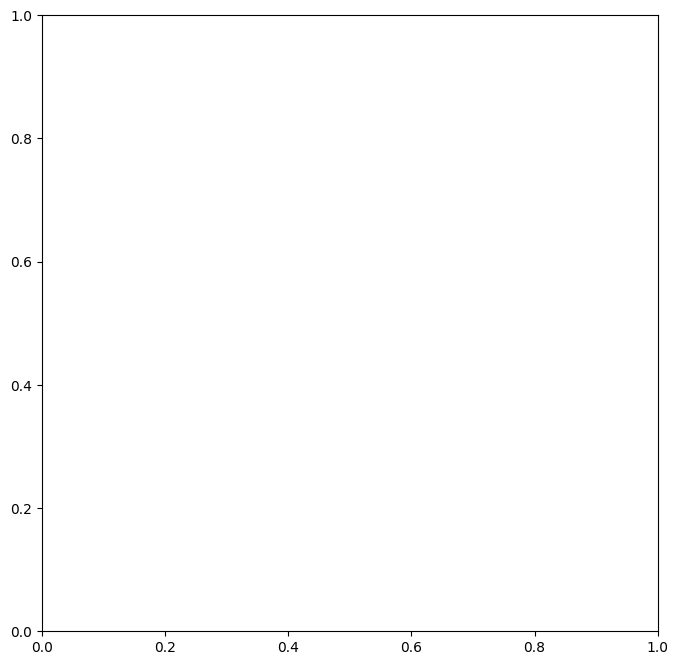

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))

def update(frame):
    ax.clear()
    ax.imshow(yearly_ndwi.isel(time=frame), cmap='GnBu', vmin=-1, vmax=1)
    # ax.set_title(f"{yearly_ndwi['time'][frame].dt.strftime('%Y').values}")
    ax.set_title(f"{yearly_ndwi['time'][frame].dt.strftime('%Y').values}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([])
    ax.set_yticks([])

ani = FuncAnimation(fig, update, frames=len(yearly_ndwi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 